# Python install

In [ ]:
%%capture
!pip install -q flair
!pip install -q SPARQLWrapper
!pip install -q sentence-transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
issa_drive_path = "/content/drive/MyDrive/PhD/Hackathon/ISSA/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import itertools
import numpy as np
import pandas as pd
from heapq import nsmallest
from flair.data import Sentence
from scipy.spatial import distance
from SPARQLWrapper import SPARQLWrapper, JSON
from flair.embeddings import WordEmbeddings
from flair.embeddings import SentenceTransformerDocumentEmbeddings

## Document embedding
Here we use **bert-base-multilingual-cased** but you can try whith the model you want from Huggingface 🤗. 

You can also use your own tuned model by giving the path.

In [ ]:
%%capture
document_embedding = SentenceTransformerDocumentEmbeddings('bert-base-multilingual-cased')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Descriptor extractions

In [ ]:
# The saves are from this file: https://colab.research.google.com/drive/1Kj9s9iu9QnboxsPKIetMm1A6024oS2fi?usp=sharing
df_cacao = pd.read_csv(issa_drive_path + 'cacao_376.csv')
df_importation = pd.read_csv(issa_drive_path + 'importation_390.csv')

### HACK LOAD EMBEDDINGS FOR COLAB ### 
# Save np.load
np_load_old = np.load
# Modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
# Call load_data with allow_pickle implicitly set to true
cacao_embeddings = np.load(issa_drive_path + 'cacao_doc_embeddings.npy')
importation_embeddings = np.load(issa_drive_path + 'importation_doc_embeddings.npy')
# Restore np.load for future normal usage
np.load = np_load_old

# Attribute embeddings
df_cacao["Embedding"] = cacao_embeddings
df_importation["Embedding"] = importation_embeddings

# Here we have a save of Cacao and Importation
saved_uri = {
  "http://aims.fao.org/aos/agrovoc/c_7713": df_cacao, # cacao
  "http://aims.fao.org/aos/agrovoc/c_3815": df_importation, # importation
} 

# Fake example
Doc A have the *descriptors* **Cacao** and **Importation**

In [ ]:
# We have the uri for Cacao and Importation
doc_a_descriptors = ["http://aims.fao.org/aos/agrovoc/c_7713", "http://aims.fao.org/aos/agrovoc/c_3815"]

## 1/ Descriptor analysis
Now we want to have a deeper look at the descriptors but, from the abstract point of view.

Did all the document about Cacao are really talking about the same things?

Lets have a similarity analysis based on all the Cacao abtracts

In [ ]:
def get_distances(uri):
  results_df = saved_uri[uri]
  results_df['CosinDistances'] = None
  cosine_distances = []
  # Dirty first try of cosin dist 
  for i, i_row in results_df.iterrows():
    # if i < 20:
      cosine_distances.append([])
      for j, j_row in results_df.iterrows():
        # if j < 20:
          # if i == j: cosine_distances[i].append(1)
          # else: cosine_distances[i].append(distance.cosine(i_row["Embedding"], j_row["Embedding"]))
          cosine_distances[i].append(distance.cosine(i_row["Embedding"], j_row["Embedding"]))
      results_df.at[i, 'CosinDistances'] = cosine_distances[i]

In [ ]:
cacao_uri = doc_a_descriptors[0]
# Get the Cosin Distances
# Take some secondes, 30s for cacao matrix of 376 embeddings
get_distances(cacao_uri)
print(saved_uri[cacao_uri]["CosinDistances"])

0      [0, 0.2412421703338623, 0.23051655292510986, 0...
1      [0.2412421703338623, 0, 0.3122742176055908, 0....
2      [0.23051655292510986, 0.3122742176055908, 0, 0...
3      [0.3406294584274292, 0.27018266916275024, 0.35...
4      [0.1086227297782898, 0.20985692739486694, 0.19...
                             ...                        
372    [0.26556533575057983, 0.33476948738098145, 0.3...
373    [0.2132827639579773, 0.06397384405136108, 0.26...
374    [0.11960053443908691, 0.23582524061203003, 0.1...
375    [0.3954085111618042, 0.3171532154083252, 0.398...
376    [0.1995229721069336, 0.06051933765411377, 0.24...
Name: CosinDistances, Length: 377, dtype: object


### A/ Visual analysis

In [ ]:
# libraries
import seaborn as sns
import pandas as pd
import numpy as np

# plot a heatmap with annotation
### BE CARFULL SUUUUPER BIG AND LONG (8min) ###
### Uncoment that to try ### 
# sns.set(rc={'figure.figsize':(200,200)})
# sns.heatmap(pd.DataFrame(cosine_distances), annot=True, annot_kws={"size": 7})

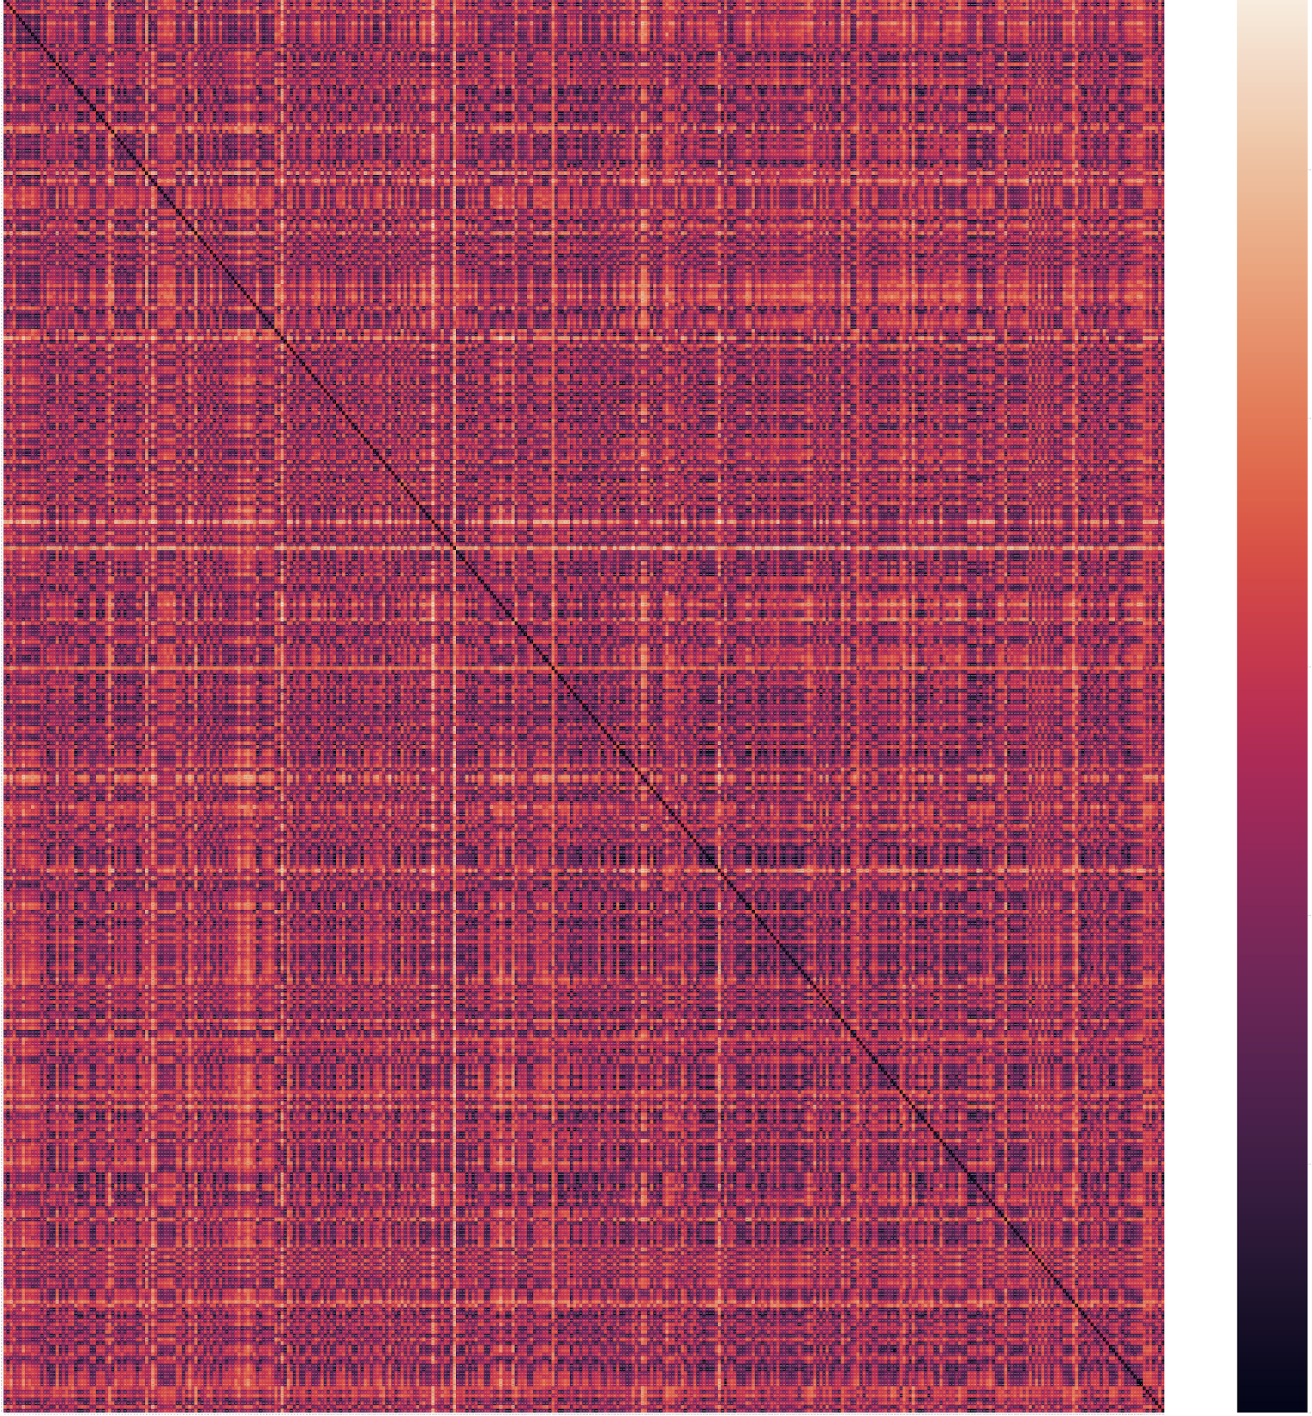

Okay, fuzzy but we can see some interesting points that we can investigate in details.

First, what are these white lines???

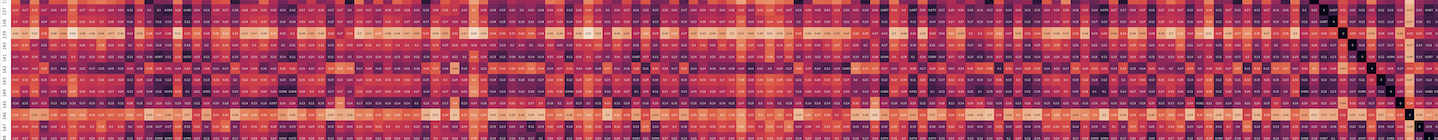

They occur in multiple places for document 139 and 146 for example.

The darker is the color, the closer are our two documents so these lines mean that a document (id 139 for example) if far, from the abstract embeddings point of view, that all the others documents tagged with descriptor Cacao.

Let’s check these lines for the Cacao descriptor.

In [ ]:
# Return document id in dataframe and sum of cosine distances
def find_errors(df):
  cosin_distances = df["CosinDistances"]
  errors = []
  for i, cosin_distance in enumerate(cosin_distances):
    euristic = sum(cosin_distance)/len(cosin_distances)
    # if euristic < 0.2: print("low", i, euristic)
    ### HERE WE HARDCODE THE THERSHOLD ###
    if euristic > 0.35: errors.append([i, df.iloc[i]["paper.value"], euristic])
    # print(i, euristic)
  return errors

In [ ]:
potentials_errors = find_errors(df_cacao)
for p_error in potentials_errors:
  print(p_error)

[90, 'http://data-issa.cirad.fr/article/312633', 0.35898887818624864]
[139, 'http://data-issa.cirad.fr/article/479501', 0.38613987538163164]
[146, 'http://data-issa.cirad.fr/article/479503', 0.42715338663017716]
[178, 'http://data-issa.cirad.fr/article/545391', 0.3709062122855958]
[232, 'http://data-issa.cirad.fr/article/515866', 0.3519805665831983]


We found them! Then we can have a look into the abstract to see if its talk about Cacao 😉

### B/ Find the bests
Now that we have our cosine distances, lets have the closest one to have a bag of similar documents.

It can be usefull for users to collect a batch of documents to read that are talking about the same things (in abstract).

In [ ]:
### TODO CHECK IF WE WANT MAX OR MIN ??? ###
def find_bests(results_df, df_id, n_top):
  # We add 1 for the case of doc X compare to doc X
  n_top += 1
  row = results_df.iloc[df_id]
  print(row["CosinDistances"])
  my_list = row["CosinDistances"]
  max_values = nsmallest(n_top, my_list)
  print("Best match for", df_id, row["paper.value"])
  max_indexes = []
  for max_value in max_values[1:]:
    max_index = my_list.index(max_value)
    max_indexes.append(max_index)
    print("Is", max_index, results_df.iloc[max_index]["paper.value"])
    print("Distance is", max_value)
    print("Lang is", row["lang.value"], results_df.iloc[max_index]["lang.value"])
  print("-------")
  return max_indexes

In [ ]:
print(find_bests(df_cacao, 178, 3))
print(find_bests(df_cacao, 146, 3))

[0.36372947692871094, 0.3728615641593933, 0.4532301425933838, 0.41433948278427124, 0.3581535816192627, 0.3098132610321045, 0.41789519786834717, 0.4127765893936157, 0.37269002199172974, 0.3803204298019409, 0.354159951210022, 0.33752721548080444, 0.3306785821914673, 0.3295472264289856, 0.3852803707122803, 0.3524947166442871, 0.3667128086090088, 0.42217791080474854, 0.3493310213088989, 0.3585343360900879, 0.33917438983917236, 0.3900876045227051, 0.38614702224731445, 0.35613352060317993, 0.3950071334838867, 0.4055602550506592, 0.33458423614501953, 0.37567436695098877, 0.3813263773918152, 0.3827217221260071, 0.3729825019836426, 0.37775522470474243, 0.3781832456588745, 0.3836174011230469, 0.43565863370895386, 0.4002911448478699, 0.38761430978775024, 0.3800652027130127, 0.3584287762641907, 0.3991871476173401, 0.3855316638946533, 0.3806254267692566, 0.3401852250099182, 0.3643034100532532, 0.34317755699157715, 0.37402456998825073, 0.4482061266899109, 0.34077805280685425, 0.49191534519195557, 0.

TADA 🎉 